In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
from random import uniform, seed
from math import sqrt
import numpy as np
from Cell2D import Cell2D, draw_array
from matplotlib.colors import LinearSegmentedColormap
from scipy import signal
import seaborn as sns
from matplotlib import cm
from numpy import random
palette = sns.color_palette()
colors = 'white', 'red', 'blue', 'orange'
cmap = LinearSegmentedColormap.from_list('cmap', colors)

In [2]:
# Defining a cmap that we can use where zeros (empty houses) will stand out - setting them to black
cmap_show_empty = cm.YlOrRd.copy()
cmap_show_empty.set_bad(color='black')

In [3]:
seed(10)

In [97]:
# Defining a class for the houses
class grid_houses(Cell2D):
    """Represents a grid of Schelling agents."""
    
    def __init__(self, n, prob_empty,kernel):
        """Initializes the attributes.
        
        n: is the dimension of our square numpy array (n x n)

        """
        super().__init__(n)
        self.prob_empty = prob_empty    # probability of empty cells occurring
        self.kernel = kernel

        choices = np.array([0,1])
        probs1 = [1/3, 1/3, 1/3]
        choices1 = np.array([0.1,0.5,1], dtype = np.int8)


        #self.values = np.random.choice([1,2,3], size = (n, n), p = [1/3,1/3,1/3])# uniformly distribute the house values between 0 and 1
        self.values = np.random.rand(n,n)
        #self.values = 0.05*self.values**2 + 0.25+self.values - 0.2
        self.array = np.random.choice(2, (n, n), p = [prob_empty, 1-prob_empty]) # randomly choosing which houses are empty, with probability prob_empty

        self.padding = np.ones_like(self.array)
        self.padding[0,:] = np.zeros_like(self.padding[0,:])
        self.padding[1,:] = np.zeros_like(self.padding[1,:])
        self.padding[-1,:] = np.zeros_like(self.padding[-1,:])
        self.padding[-2,:] = np.zeros_like(self.padding[-2,:])
        self.padding[:,0] = np.zeros_like(self.padding[:,0])
        self.padding[:,1] = np.zeros_like(self.padding[:,1])
        self.padding[:,-1] = np.zeros_like(self.padding[:,-1])
        self.padding[:,-2] = np.zeros_like(self.padding[:,-2])

        self.array = np.multiply(self.padding, self.array) # setting the house indicator to zero for the padding
        self.values= np.multiply(self.values, self.array) # sets the house values to zero if there is no house at that spot

    def average_neighbors(self):
        '''
        calculates the of the values of neighbors' house values, where the radius is defined by the kernel matrix. Note - boundary = fill automatically 'pads' the matrix with zeros on the boundary, which leads to lower averages there, so lower house prices near the boundary. We should look into a wrap boundary or possibly filling with a different value, eg average house price.
        :return: array of the averages
        '''
        total = signal.convolve2d(self.values, self.kernel, boundary='wrap', mode='same')
        # adding the number of total grid points
        number = signal.convolve2d(self.array, self.kernel, boundary='wrap', mode='same')

        # finding the average
        average = np.zeros_like(self.array, dtype = float)
        average[2:-2,2:-2] += np.divide(total[2:-2,2:-2],number[2:-2,2:-2])


        # resetting the values to zero for squares that don't have a house
        output = np.multiply(self.array,average)
        output = np.multiply(output, self.array) # setting the house indicator to zero for the padding
        return(output)

    def draw_values(self):
        '''
        Just defined a function to draw the house values so we can draw both a map of houses and a map of house values
        '''
        # mask some 'bad' data, in your case you would have: data == 0
        values = np.ma.masked_where(self.values == 0, self.values)
        return draw_array(values, cmap = cmap_show_empty)

    def update_values(self, grid_agents, lam):
        '''
        Coding for the function we use to update house prices, at a matrix level. We can use
        :param grid_agents:
        :param lam:
        :return:
        '''
        self.values = lam*self.average_neighbors() + grid_agents.affluences

    def draw_neighbors(self):
        return draw_array(self.average_neighbors())


In [98]:
# Defining a class for the agents
class grid_agents(Cell2D):
    """Represents a grid of Schelling agents."""

    def __init__(self, n, prob_empty,grid_houses):
        """Initializes the attributes.
        """
        super().__init__(n)
        #self.affluences = np.random.rand(n,n)
        self.prob_emp = prob_empty    # probability of empty cells occurring
        # self.prob_rich = (1 - self.prob_emp)/3
        # self.prob_middle= (1 - self.prob_emp)/3
        # self.prob_poor = (1 - self.prob_emp)/3
        self.size = n
        # limiting this to just two, the zeros here give us empty houses, but I'm not sure this is really necessary since we just swap people's houses anyway.
        # use the numpy routine choice to select the different cells with probability
        #self.array = np.random.choice(choices, (n, n), p = probs)
        # self.array = np.multiply(self.array,grid_houses.array)
        choices = np.array([0.1,.5,1])
        probs = [1/3, 1/3, 1/3]
        #self.affluences = np.random.choice(choices, (n, n), p = probs)
        self.affluences = np.random.rand(n,n)
        self.affluences = np.multiply(self.affluences,grid_houses.array)


    def draw(self):
        """Draws the cells."""
        return draw_array(self.array, cmap=cmap, vmax=3)

    def draw_affluences(self):
        '''
        Draws the grid of affluences.
        '''
        # mask some 'bad' data, in your case you would have: data == 0
        affluences = np.ma.masked_where(self.affluences == 0, self.affluences)
        return draw_array(affluences, cmap = cmap_show_empty)

    def swap_people(self, grid_houses):
        '''
        Picks two random grid elements, if they aren't zero and the delta function is greater than 0, swaps them
        :param grid_houses: we need this as an input, since we need to get house values for the two agents, for the delta function.
        :return:
        '''
        i1 = random.randint(2,self.size-2)
        j1 = random.randint(2,self.size-2)
        i2 = random.randint(2,self.size -2)
        j2 = random.randint(2,self.size-2)

        if j1 != j2 or i1 != i2:
            if grid_houses.array[i1][j1] != 0 and grid_houses.array[i2][j2] != 0:
                print(grid_houses.values[i1][j1])
                t1 = (grid_houses.values[i1][j1]- self.affluences[i1][j1])**2 + (grid_houses.values[i2][j2]- self.affluences[i2][j2])**2
                t2 = (grid_houses.values[i1][j1]- self.affluences[i2][j2])**2 + (grid_houses.values[i2][j2]- self.affluences[i1][j1])**2
                if t1 > t2:
                    self.affluences[i2,j2], self.affluences[i1,j1] = self.affluences[i1,j1],self.affluences[i2,j2]

    def swap_exists(self, grid_houses):
        '''
        Picks two random grid elements, if they aren't zero and the delta function is greater than 0, swaps them
        :param grid_houses: we need this as an input, since we need to get house values for the two agents, for the delta function.
        :return:
        '''
        print(self.affluences)
        print(grid_houses.values)
        x1 = range(self.array.shape[1])
        x2 = range(self.array.shape[0])
        y1 =range(self.array.shape[1])
        y2 =range(self.array.shape[0])
        x1 = list(x1)
        x2 = list(x2)
        y1 = list(y1)
        y2 = list(y2)
        random.shuffle(x1)
        random.shuffle(x2)
        random.shuffle(y1)
        random.shuffle(y2)

        for i1 in x1:
            for j1 in x2:
                for i2 in y1:
                    for j2 in y2:
                        if j1 != j2 or i1 != i2:
                            if grid_houses.array[i1][j1] != 0 and grid_houses.array[i2][j2] != 0:
                                t1 = (grid_houses.values[i1][j1]- self.affluences[i1][j1])**2 + (grid_houses.values[i2][j2]- self.affluences[i2][j2])**2
                                t2 = (grid_houses.values[i1][j1]- self.affluences[i2][j2])**2 + (grid_houses.values[i2][j2]- self.affluences[i1][j1])**2
                                # print("t1 =",t1)
                                # print("t2 =",t2)
                                if t1 > t2:
                                    return True
        return False

In [99]:
# kernel used for counting a cell's neighbours
kernel = np.array([[1,1,1, 1, 1],
                   [1,1,1, 1, 1],
                   [1,1, 1, 1,1],
                   [1,1,1, 1, 1],
                   [1,1,1, 1, 1]], dtype=np.int8)

## Running the code (100,000 times)

In [100]:
# setting up the grids, with 0.1 the probability of an empty space. Note that the 0.1 argument in grid_agents does nothing currently. It originally referred to the probability of a house being empty, but we don't have empty houses now
grid_houses1 = grid_houses(9,.1, kernel)
grid_agents1 = grid_agents(9, 0.1, grid_houses1)

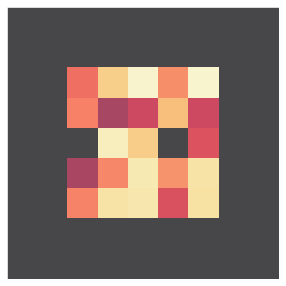

In [101]:
grid_houses1.draw_values()

### setting $\lambda_1$ = 0.8 and $\lambda_2 = 0.15$

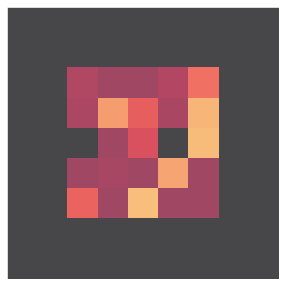

In [102]:
grid_houses1.update_values(grid_agents1,0.8)
grid_agents1.swap_people(grid_houses1)
grid_houses1.draw_values()

In [103]:
for i in range(50):
    if i % 1000 == 0:
        print(i)
    grid_houses1.update_values(grid_agents1, 0.55)
    grid_agents1.swap_people(grid_houses1)

0


50,000 steps is quite quick and seems to lead to convergence in the way we would expect

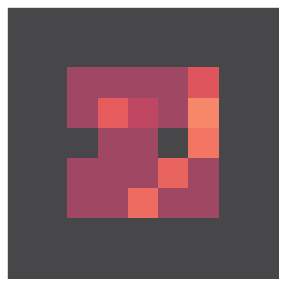

In [104]:
grid_houses1.draw_values()

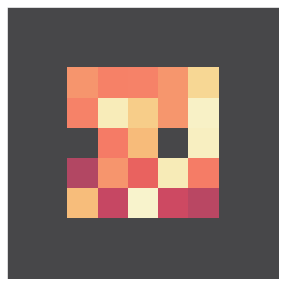

In [105]:
grid_agents1.draw_affluences()

# Experimenting with different values of $\lambda_1$ and $\lambda_2$

In [106]:
# setting the gridsize (we add 4 for the boundary)
gridsize = 100

# setting up grids
grid_houses1 = grid_houses(gridsize + 4,.1, kernel)
grid_agents1 = grid_agents(gridsize + 4, 0.1, grid_houses1)

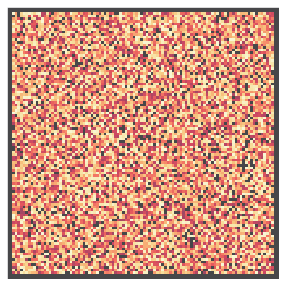

In [107]:
# examining the results
grid_houses1.draw_values()

In [108]:
grid_houses1.update_values(grid_agents1, 0.6)
grid_agents1.swap_people(grid_houses1)

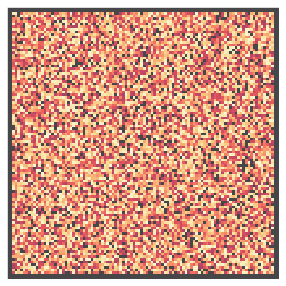

In [109]:
grid_agents1.draw_affluences()

In [112]:
for i in range(100000):
    if i % 1000 == 0:
        print(i)
    grid_houses1.update_values(grid_agents1, 0.6)
    grid_agents1.swap_people(grid_houses1)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000


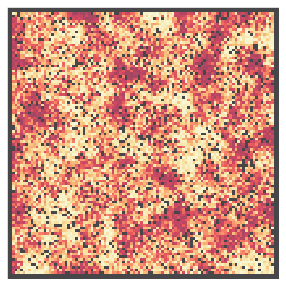

In [113]:
grid_agents1.draw_affluences()

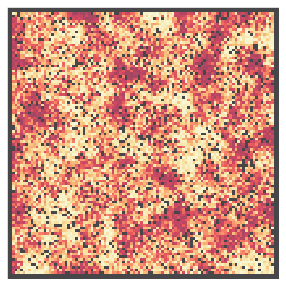

In [121]:
grid_agents1.draw_affluences()

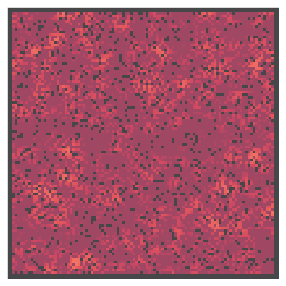

In [35]:
grid_houses1.draw_values()

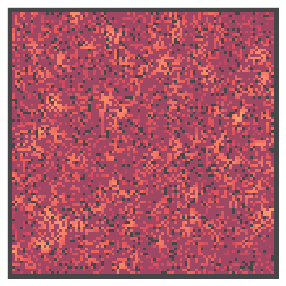

In [102]:
grid_houses1.draw_values()

# Calculating Inequality

In [30]:
def inequality(A):
    """
    Function to find inequality given the aflluence matrix A
    """
    poor = 0
    middle = 0
    rich = 0

    for x in range(np.shape(A)[0]):
        for y in range(np.shape(A)[1]):
            if float(A[x,y]) == 0.1:
                poor += 1
            elif float(A[x,y]) == 0.5:
                middle += 1
            elif float(A[x,y]) == 1.0:
                rich += 1
    sum = poor+middle+rich
    print(f'{np.log(3)}+{poor/sum}*{np.log(poor/sum)}')
    I = np.log(3) + (poor/sum) * np.log(poor/sum) + (middle/sum) * np.log(middle/sum) + (rich/sum) * np.log(rich/sum)
    return(I)

In [31]:
def theil_inequality(A):
    avg = np.average(A)
    print('average = ', avg)
    return A/avg * np.log( A/avg )

In [32]:
inequality_values = []
print(np.log(3))

for x in range(0,10):
    grid_houses1 = grid_houses(19,.1, kernel)
    grid_agents1 = grid_agents(19, 0.1, grid_houses1)
    inequality_values.append(theil_inequality(grid_agents1.affluences))
    print('THeil: ', theil_inequality(grid_agents1.affluences))

1.0986122886681098
average =  0.2581717451523546
average =  0.2581717451523546
THeil:  [[        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan]
 [        nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan         nan         nan         nan         nan         nan
          nan]
 [        nan         nan         nan -0.36737361  1.28012276  1.28012276
  -0.36737361 -0.36737361         nan  1.28012276  1.28012276  1.28012276
   5.24507527  5.24507527  1.28012276 -0.36737361  1.28012276         nan
          nan]
 [        nan         nan  1.28012276         nan  1.28012276  5.24507527
  -0.36737361  1.28012276 -0.36737361 -0.36737361  5.24507527 -0.36737361
   1.28012276  5.24507527 -0.36737361  1.28012276 -0.3

C:\Users\Administrator\AppData\Local\Temp\ipykernel_22340\2051646313.py:4: RuntimeWarning: divide by zero encountered in log
  return A/avg * np.log( A/avg )
C:\Users\Administrator\AppData\Local\Temp\ipykernel_22340\2051646313.py:4: RuntimeWarning: invalid value encountered in multiply
  return A/avg * np.log( A/avg )


# Making a graph of (inflation)

In [113]:
gridsize = 50
averages = []
lam = []

for i in range(40,61):
    print(i)
    lam = i/100
    # setting the gridsize (we add 4 for the boundary)
    # setting up grids
    grid_houses1 = grid_houses(gridsize + 4,.1, kernel)
    grid_agents1 = grid_agents(gridsize + 4, 0.1, grid_houses1)

    for i in range(10000):
        grid_houses1.update_values(grid_agents1, lam)
        grid_agents1.swap_people(grid_houses1)
    averages.append(np.average(grid_houses1.values))

40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60


In [114]:
print(averages)

[0.687652031536686, 0.7056751891001349, 0.7149315749357541, 0.7119969785852661, 0.7436663045072702, 0.7442125634661286, 0.745532105459113, 0.7690013957897139, 0.7838576800861898, 0.7748274371478139, 0.8234975994430065, 0.8274630893966829, 0.8726741694918377, 0.8730200500736939, 0.8979842017379019, 0.914441976735955, 0.8866614530031252, 0.9624766270935022, 0.9953896831910617, 1.006705627995528, 1.0509797565508725]


# Getting convergence rates for different $\lambda$

In [155]:
def get_convergence(lam, gridsize, p_empty):
    grid_houses1 = grid_houses(gridsize + 4,p_empty, kernel)
    grid_agents1 = grid_agents(gridsize + 4, p_empty, grid_houses1)
    i = 0
    j = 0
    while i < gridsize**2:
        grid_houses1.update_values(grid_agents1, lam)
        g1 = grid_agents1.affluences.copy()
        grid_agents1.swap_people(grid_houses1)
        g2 = grid_agents1.affluences
        if np.array_equal(g1,g2):
            i += 1
        else:
            i = 0
        j += 1
    return j, np.average(grid_houses1.values)

In [156]:
get_convergence(0.1, 20, 0.2)

(697, 0.2732037802403087)

In [157]:
# graphing 'convergence' for different values of lambda
lambdas = []
convergence = []
inflation = []

for t in range(1,50):
    print(t)
    lam = t/50
    conv, inf = get_convergence(lam, 20, 0.2)
    lambdas.append(lam)
    convergence.append(conv)
    inflation.append(inf)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


C:\Users\Administrator\AppData\Local\Temp\ipykernel_18492\4010086743.py:5: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "fontsize" which is no longer supported as of 3.3 and will become an error in 3.6
  plt.savefig('lambda_inflation_2.pdf',fontsize=20)


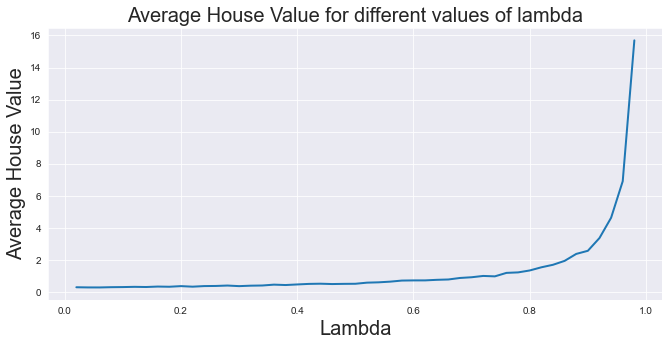

In [163]:
plt.plot(lambdas, inflation)
plt.title('Average House Value for different values of lambda',fontsize=20)
plt.xlabel('Lambda',fontsize=20)
plt.ylabel('Average House Value',fontsize=20)
plt.savefig('lambda_inflation_2.pdf',fontsize=20)

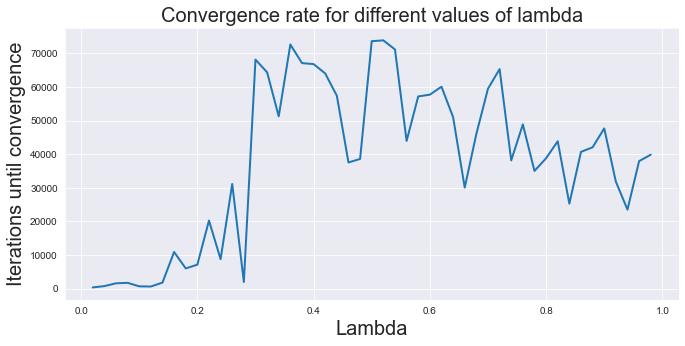

In [164]:
plt.plot(lambdas, convergence)
plt.title('Convergence rate for different values of lambda',fontsize=20)
plt.xlabel('Lambda',fontsize=20)
plt.ylabel('Iterations until convergence',fontsize=20)
plt.savefig('lambda_convergence_2.pdf')

In [ ]:
# graphing 'inflation' for different values of lambda
lambdas = []
convergence = []

for t in range(1,50):
    print(t)
    lam = t/50
    conv = get_convergence(lam, 20, 0.2)
    lambdas.append(lam)
    convergence.append(conv)